## Subset MIMIC-III data retrieval (Google Drive)

In [ ]:
# Load and prepare our data
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/bq-results-20241104-203347-1730762295048/bq-results-20241104-203347-1730762295048.csv'

# Read the CSV exported from BigQuery via Google Drive
df = pd.read_csv(file_path)

print(df.head())

Mounted at /content/drive
   hadm_id gender  age admission_type         admission_location insurance  \
0   109129      M   53      EMERGENCY       EMERGENCY ROOM ADMIT  Medicare   
1   133732      F   60         URGENT  TRANSFER FROM HOSP/EXTRAM   Private   
2   173950      F   33      EMERGENCY       EMERGENCY ROOM ADMIT  Medicaid   
3   121512      F   20      EMERGENCY       EMERGENCY ROOM ADMIT   Private   
4   189942      M   39      EMERGENCY       EMERGENCY ROOM ADMIT  Self Pay   

   sepsis_diagnosis  creatinine  hemoglobin      sodium  ...     glucose  \
0                 0        0.40         NaN  141.333333  ...   79.666667   
1                 0        0.80         NaN  135.000000  ...  209.000000   
2                 0        0.50       10.20  145.000000  ...   79.000000   
3                 0        0.65       11.95  141.333333  ...  128.666667   
4                 0        0.85         NaN  136.500000  ...  115.000000   

         bun    platelet  heart_rate  systolic_b

In [ ]:
print(df.columns)

Index(['hadm_id', 'gender', 'age', 'admission_type', 'admission_location',
       'insurance', 'sepsis_diagnosis', 'creatinine', 'hemoglobin', 'sodium',
       'potassium', 'bicarbonate', 'glucose', 'bun', 'platelet', 'heart_rate',
       'systolic_bp', 'respiratory_rate', 'mechanical_ventilation',
       'venous_catheterization', 'dialysis', 'length_of_stay_days'],
      dtype='object')


# Data Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [ ]:
# Separate features and target
x = df.drop(['length_of_stay_days', 'hadm_id'], axis=1)
y = df['length_of_stay_days']

In [ ]:
# Convert categorical variables into dummy variables
cols_cat = ['gender', 'admission_type', 'admission_location', 'insurance']
x_dum_vars = pd.get_dummies(x, columns=cols_cat)

In [ ]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(x_dum_vars, y, test_size=0.2, random_state=42)

In [ ]:
# Handle the missing values with median imputation
imputer = SimpleImputer(strategy='median')
num_cols = x.select_dtypes(include=['int64', 'float64']).columns
x_train[num_cols] = imputer.fit_transform(x_train[num_cols])
x_test[num_cols] = imputer.transform(x_test[num_cols])

In [ ]:
# Scale features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Instantiate model types

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize models (up to choice)
model = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    # Baseline # of trees to start off -> n_estimators
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
}

# Train and generate predictions from models

In [ ]:
import numpy as np

# Begin to train and evaluate each model
results = {}
for model_name, model_type in model.items():
    # Train step
    model_type.fit(x_train_scaled, y_train)

    # Prediction step
    y_pred = model_type.predict(x_test_scaled)

    # Calculate metrics for all present models
    results[model_name] = {
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_squared_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred),
    }

In [ ]:
for model_name, model_metrics in results.items():
    print(f"{model_name} Metrics:")
    for metric_name, metric_value in model_metrics.items():
        print(f"{metric_name}: {metric_value}")

Linear Regression Metrics:
MSE: 331.47921612332357
RMSE: 18.206570685423532
MAE: 331.47921612332357
R2: 0.2363315242832723
XGBoost Metrics:
MSE: 288.39798062768045
RMSE: 16.982284317125316
MAE: 288.39798062768045
R2: 0.3355829398854835
Random Forest Metrics:
MSE: 242.0071556804486
RMSE: 15.556579176684332
MAE: 242.0071556804486
R2: 0.4424590541378889


# Random Forest model - most important features

In [ ]:
# We can view which features Random Forest labeled with high importance
rand_forest_model = model['Random Forest']
feat_imprt = pd.DataFrame({
    'feature': x_train.columns,
    'importance': rand_forest_model.feature_importances_
})
feat_imprt.sort_values('importance', ascending=False)

,feature,importance
23,admission_location_CLINIC REFERRAL/PREMATURE,0.174065
6,bicarbonate,0.173523
4,sodium,0.141547
10,heart_rate,0.140435
9,platelet,0.129138
5,potassium,0.095443
0,age,0.019508
31,insurance_Medicaid,0.018453
7,glucose,0.016688
11,systolic_bp,0.014803


# Bar plot of feature importance for Random Forest model

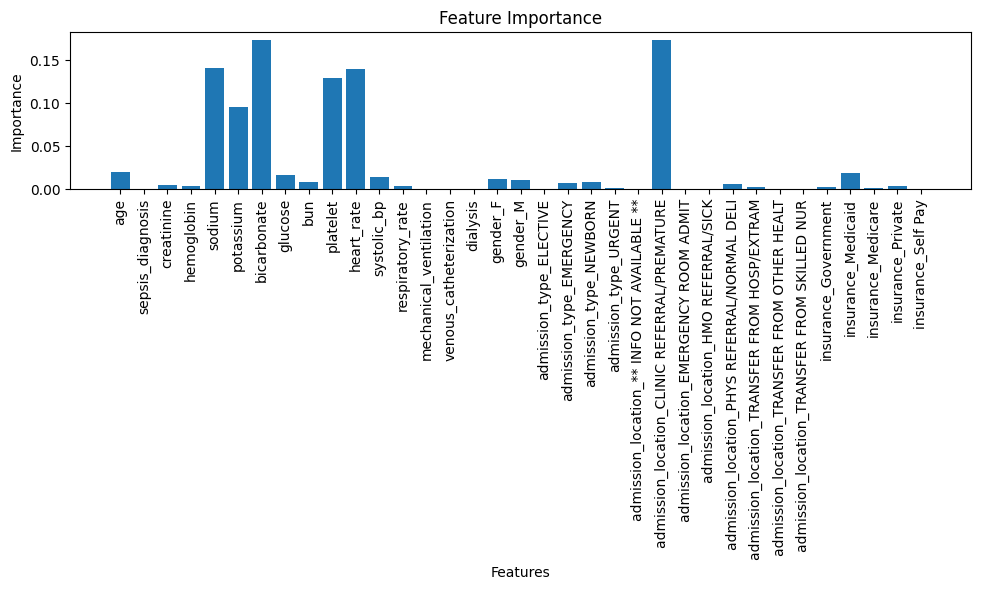

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(feat_imprt['feature'], feat_imprt['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Scatter plot of Random Forest model prediction results

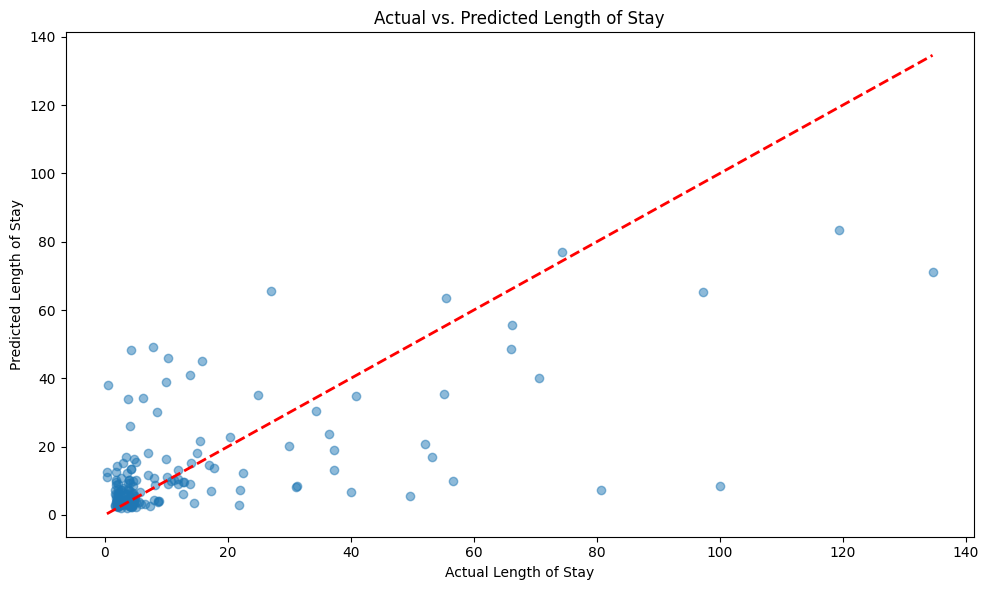

In [ ]:
# Full range plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, model['Random Forest'].predict(x_test_scaled), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Length of Stay')
plt.ylabel('Predicted Length of Stay')
plt.title('Actual vs. Predicted Length of Stay')
plt.tight_layout()
plt.show()

# Scatter plot of Random Forest model prediction results (zoomed in)

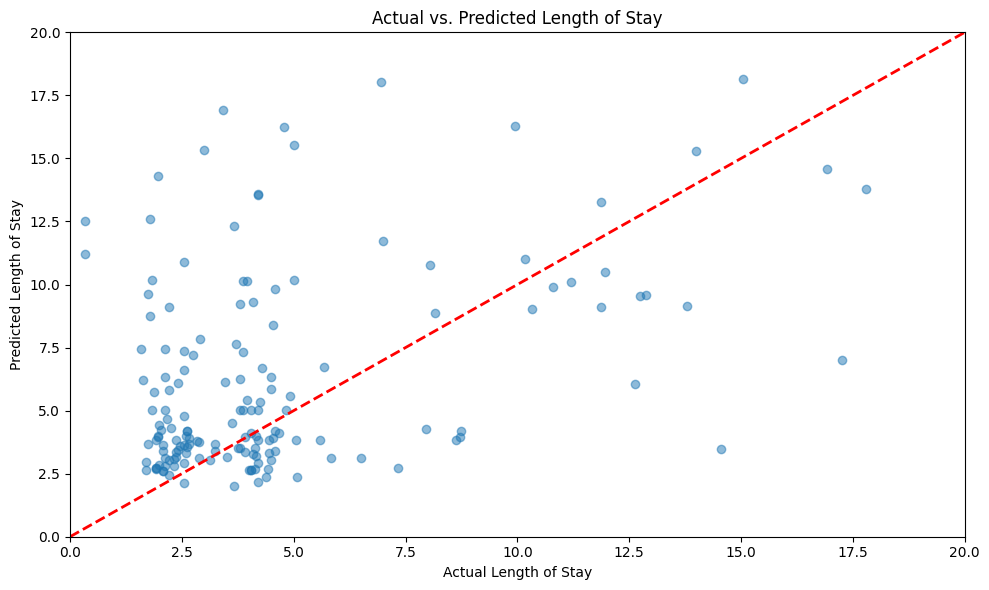

In [ ]:
# Restricted range plot (0-20 days)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, model['Random Forest'].predict(x_test_scaled), alpha=0.5)
plt.plot([0, 20], [0, 20], 'r--', lw=2)
ax = plt.gca()
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
plt.xlabel('Actual Length of Stay')
plt.ylabel('Predicted Length of Stay')
plt.title('Actual vs. Predicted Length of Stay')
plt.tight_layout()
plt.show()

# Plot of distribution of errors for all models

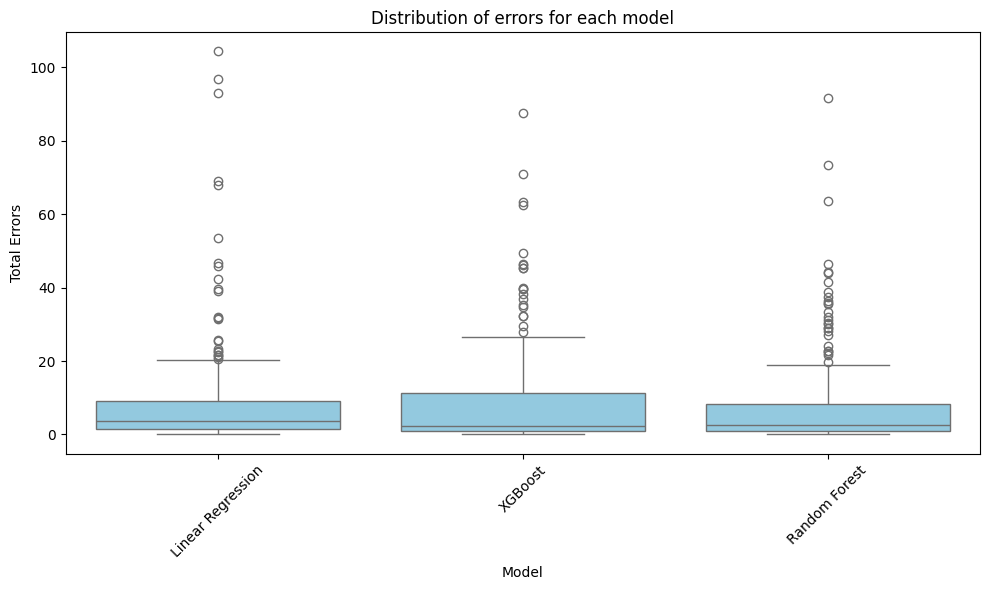

In [ ]:
import seaborn as sns

# Create error data in a cleaner way
total_errors = []
model_names = []
for model_name, model_type in model.items():
    # Re-evaluate the models again (results should be very similar)
    errs = abs(y_test - model_type.predict(x_test_scaled))
    for err in errs:
      total_errors.append({
          'Model': model_name,
          'Total Errors': err
      })

err_df = pd.DataFrame(total_errors)

# Create box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Total Errors', data=err_df, color='skyblue')
plt.xticks(rotation=45)
plt.title('Distribution of errors for each model')
plt.tight_layout()
plt.show()

# Values of actual vs. predicted for all model predictions

In [67]:
# Printing detailed performance metrics
print("\nSample of Actual vs. Predicted Length of Stay:")
compare_df = pd.DataFrame({
    'Actual': y_test,
    'Linear Regression': model['Linear Regression'].predict(x_test_scaled),
    'XGBoost': model['XGBoost'].predict(x_test_scaled),
    'Random Forest': model['Random Forest'].predict(x_test_scaled),
})
print(compare_df.head(50))


Sample of Actual vs. Predicted Length of Stay:
         Actual  Linear Regression    XGBoost  Random Forest
521   14.541667          21.864236   3.861816       3.461667
737    4.208333           3.749001   3.292488       2.186320
740    2.000000           2.225564  48.074524       4.415629
660    4.583333           3.155251   3.330168       4.173583
411    8.625000           4.166970   3.891531       3.843546
678    4.041667           4.819314   3.630753       2.631983
626    2.458333           6.260720   2.870272       3.586583
513   34.333333          50.653298  38.780281      30.463000
859    6.500000           9.118142   2.775623       3.118750
136    3.708333           2.264626  10.139591       7.625917
811    2.416667           6.321267   2.818784       3.440676
76     1.791667          16.709939   6.773108       8.753417
636    2.666667           0.350564   2.127748       3.691083
973  119.458333          26.426736  97.371132      83.591583
938   10.333333           3.397439  1

# Flat value of accuracy (R^2) for all models

In [ ]:
for model_name, model_type in model.items():
  print(f"{model_name} Accuracy (R^2): {model_type.score(x_test_scaled, y_test)}")

Linear Regression Accuracy (R^2): 0.2363315242832723
XGBoost Accuracy (R^2): 0.3355829398854835
Random Forest Accuracy (R^2): 0.4424590541378889
